# Distanciamiento Social
# Tarea 01
Alumno: Leibnitz Pavel Rojas Bustamante

# Descargamos el video y los Bounding Boxes

In [9]:
#Descargando video y bounding boxes
!wget http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
!wget http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top

--2020-05-23 17:57:14--  http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147486436 (141M) [video/x-msvideo]
Saving to: ‘TownCentreXVID.avi’

TownCentreXVID.avi  100%[===================>] 140.65M  1.47MB/s    in 1m 41s  

2020-05-23 17:58:57 (1.39 MB/s) - ‘TownCentreXVID.avi’ saved [147486436/147486436]

--2020-05-23 17:58:57--  http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5553300 (5.3M)
Saving to: ‘TownCentre-groundtruth.top’

TownCentre-groundtr 1

# Librerías y Funciones auxiliares

Con el siguiente script podemos extraer los frames del video y guardarlos como jpg.

In [9]:
%%writefile extract_towncentre.py
import os
import cv2
import numpy as np

def video2im(src, dst='images', factor=1):
    """
    Extracts all frames from a video and saves them as jpgs
    """
    try:
      os.mkdir(dst)
    except Exception as e:
      print(e)

    frame = 0
    cap = cv2.VideoCapture(src)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print('Total Frame Count:', length )
            
    """
    Limitamos la cantidad de frames a extraer. Para obtenerlos todos, 
    base con modificar el valor de limitFrame
    """
    limitFrame = 10 

    while True:
        check, img = cap.read()
        if check:
            path = dst

            if frame == limitFrame: 
              break
            
            img = cv2.resize(img, (1920 // factor, 1080 // factor))
            cv2.imwrite(os.path.join(path, str(frame) + ".jpg"), img)

            frame += 1
            print('Processed: ',frame, end = '\r')
        
        else:
            break
    
    cap.release()

if __name__ == '__main__':
    video2im('TownCentreXVID.avi')

Overwriting extract_towncentre.py


In [26]:
!python extract_towncentre.py

Total Frame Count: 7500


# Eye of Bird

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Importamos Librerías:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from math import sqrt

#Importamos Funciones Auxiliares:
"""
Importamos Funciones Auxiliares.
Fuente: https://github.com/KevenRFC/MaskDectector
Se modificó algunas funciones para renderizar las imágenes y calcular los puntos del Bird Eye. 
"""
from utils.functions import *
from utils.view import *

In [4]:
IMAGEN = "images/0.jpg"

Tamaño original del Frame:  (1080, 1920, 3)


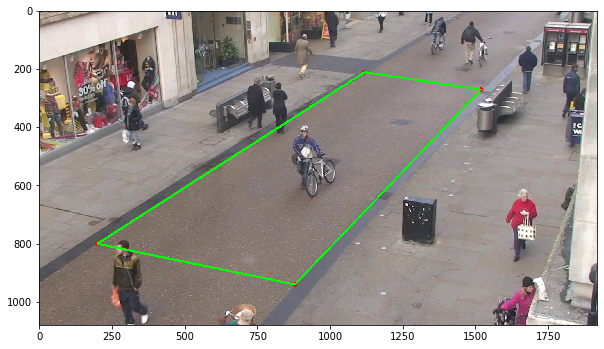

In [59]:
#Obtenemos el primer frame del video como referencia.
original = cv2.cvtColor(cv2.imread(IMAGEN), cv2.COLOR_BGR2RGB)
img = original.copy()

#Seleccionamos 4 puntos en la imagen que tomaremos como referencia.
source_points = np.float32([[1120, 210], [1520, 270] , [880,940], [200, 800] ])

#Dibujamos los puntos seleccionados en la imagen:
for point in source_points:
    cv2.circle(img, tuple(point), 8, (255, 0, 0), -1)

#Dibujamos las líneas de unión entre los puntos para formar el trapecio:
points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(img, [points], True, (0,255,0), thickness=5)

#Graficamos la imagen:
print("Tamaño original del Frame: ", img.shape)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

## Cálculo de Matrix de transformación

In [53]:
#Obtenemos los puntos de referencia de la imagen original:
src_points = source_points

width = 1000
height = 2000
dst_points = np.float32([[0,0],[width,0],[width,height],[0,height]])
dst_size=(width,height)


In [54]:
H_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
warped = cv2.warpPerspective(img, H_matrix, dst_size)

In [55]:
print("The perspective transform matrix:")
#Calculamos la matriz de homografía para la transformación:
H_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
print(H_matrix)
#Aplicamos Warp Perspective para transformar la imagen con la matriz de homografía obtenida.
warped = cv2.warpPerspective(img, H_matrix, dst_size)


The perspective transform matrix:
[[ 2.39308427e+00  3.73158903e+00 -3.46388807e+03]
 [-8.41926801e-01  5.61284534e+00 -2.35739504e+02]
 [-1.17665406e-04  1.33326098e-03  1.00000000e+00]]


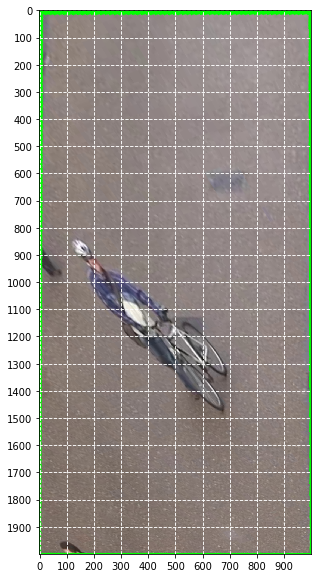

In [66]:
#Graficamos la imagen transformada:
plt.figure(figsize=(10, 10))
plt.imshow(warped)
plt.xticks(np.arange(0, warped.shape[1], step=100))
plt.yticks(np.arange(0, warped.shape[0], step=100))
plt.grid(True, color='white', linestyle='--', linewidth=0.9)
plt.show()

La calle mide aproximadamente 5 metros en la realidad. Esta medida para nuestro caso, es equivalente a 1000 pixeles. Siendo así, tomaremos en cuenta que la distancia social mínima de 1 metro sería igual a 200 pixeles.

## Cargamos los Bounding Boxes

In [57]:
columns = ['numPersona','numFrame','headValid','bodyValid','headLeft',
           'headTop','headRight','headBottom','bodyLeft','bodyTop','bodyRight','bodyBottom']
bounding_boxes = pd.read_csv("TownCentre-groundtruth.top", header=None)
bounding_boxes.columns = columns

bounding_boxes.head()

,numPersona,numFrame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


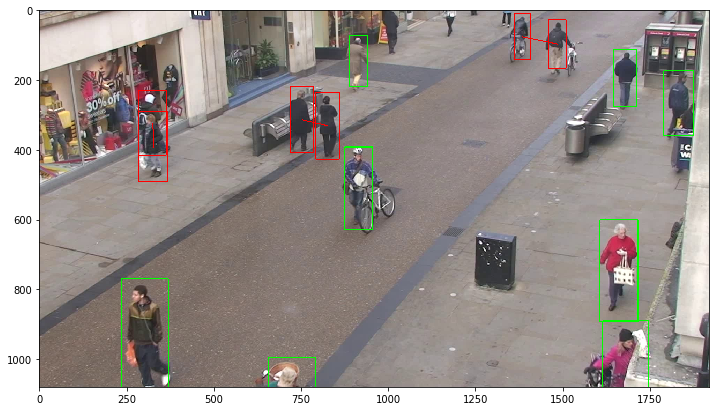

In [68]:
NFRAME = 0
#Definimos la distancia mínima permitida como 115 pixels:
min_distance = 200

b = bounding_boxes.loc[bounding_boxes.numFrame == NFRAME].copy()
person_boxes = get_domain_boxes(b)

#Evaluamos la distancia:
good, bad = people_distances_bird_eye_view(person_boxes, min_distance, H_matrix)
#print(bad)
#Generamos la imagen final con la evaluación de distancia:
new_image  = draw_new_image_with_boxes(original, good, bad, min_distance, draw_lines=True)
plt.figure(figsize=(12,12))
plt.imshow(new_image)
plt.show()

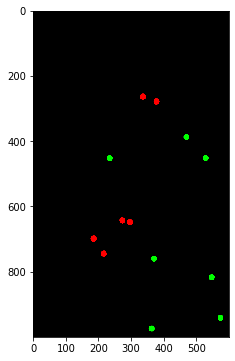

In [69]:
#Obtenemos la lista de puntos verdes y rojos:
green_points = [g[6:] for g in good]
red_points = [r[6:] for r in bad]

#Generamos la vista "Bird's Eye View" con los puntos evaluados por distancia:
bird_eye_view = generate_bird_eye_view(green_points, red_points)
plt.figure(figsize=(6,6))
plt.imshow(bird_eye_view)
plt.show()

(1254, 2604, 3)


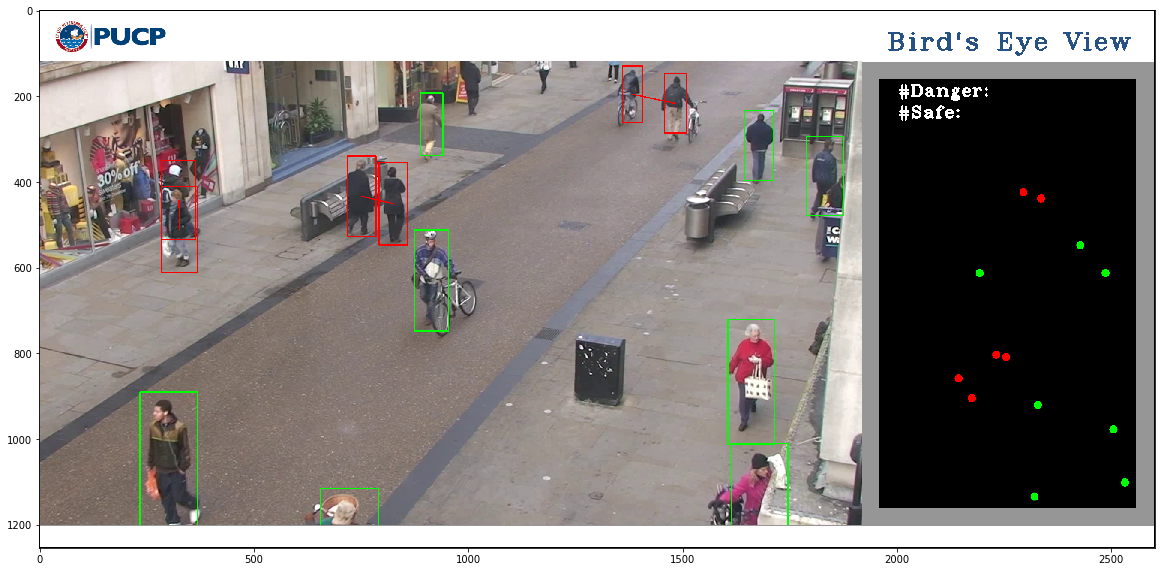

In [70]:
#Generamos el marco que contiene los textos y el logo:
picture = generate_picture()

#Ingresamos en el marco previo, la imagen original y la vista "Bird´s Eye View":
img_final = generate_content_view(picture, new_image, bird_eye_view)

img_final, _ = put_text(img_final, "#Danger: ", 200)
img_final, _ = put_text(img_final, "#Safe: ", 250)

print(img_final.shape)
plt.figure(figsize=(20,20))
plt.imshow(img_final)
plt.show()

# Procesamiento de Video

En las siguiente sección usaremos la Matrix de Homografía calculada para transformar cada uno de los frames del video y así generar uno nuevo incluyendo la vista en perspectiva Eye Bird.

In [71]:
%%time
#Importamos Librerías:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from math import sqrt

#Importamos Funciones Propias:
from utils.functions import *
from utils.view import *

min_distance = 200

matrixTransformacion = H_matrix
print("Matriz de Transaformación: ")
print(H_matrix)

writer = None
frame_width = 2604
frame_height = 1254  

picture = generate_picture()

video = cv2.VideoCapture('TownCentreXVID.avi')

columns = ['numPersona','numFrame','headValid','bodyValid','headLeft',
           'headTop','headRight','headBottom','bodyLeft','bodyTop','bodyRight','bodyBottom']
bounding_boxes = pd.read_csv("TownCentre-groundtruth.top", header=None)
bounding_boxes.columns = columns

if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output.avi', 
                             fourcc, 
                             30, 
                             (frame_width,frame_height))
    
nFrame = 0
while True:
    check, frame = video.read()
    
    if check == True:
        
        
        if frame is None:
            break

        if nFrame == 3600: #Generamos video para los 600 primeros frames
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        boxes = bounding_boxes.loc[bounding_boxes.numFrame == nFrame].copy() 

        person_boxes = get_domain_boxes(boxes)

        good, bad = people_distances_bird_eye_view(person_boxes, min_distance, matrixTransformacion)
        new_image  = draw_new_image_with_boxes(image, good, bad, min_distance, draw_lines=True)

        green_points = [g[6:] for g in good]
        red_points = [r[6:] for r in bad]

        bird_eye_view = generate_bird_eye_view(green_points, red_points)
        output_image = generate_content_view(picture, new_image, bird_eye_view)
        
        output_image, _ = put_text(output_image, "#Danger: " + str(len(red_points)), 200)
        output_image, _ = put_text(output_image, "#Safe: " + str(len(green_points)), 250)


        if writer is not None:
            
#             plt.figure(figsize=(20,20))
#             plt.imshow(output_image)
#             plt.show()  
            writer.write(output_image[:,:,::-1])

        nFrame += 1
        
    else:
        break

video.release()
writer.release()
        


Matris de Transaformación: 
[[ 2.39308427e+00  3.73158903e+00 -3.46388807e+03]
 [-8.41926801e-01  5.61284534e+00 -2.35739504e+02]
 [-1.17665406e-04  1.33326098e-03  1.00000000e+00]]
CPU times: user 5min 35s, sys: 28.2 s, total: 6min 4s
Wall time: 5min 48s
